Sentiment analysis, also known as opinion mining, is a natural language processing (NLP) technique used to determine the emotional tone or attitude expressed in a piece of text. It involves analyzing and classifying text into categories such as positive, negative, or neutral sentiment.

### Steps Involved

- **Text Preprocessing**
- **Feature Extraction**
- **Sentiment Classification**
- **Evaluation Metrics**

#### Text Preprocessing
- **Tokenization**
- **Normalization**
- **Stopword Removal**
- **Stemming/Lemmatization**


#### Feature Extraction
- **Bag of Words (BoW)**
- **TF-IDF (Term Frequency-Inverse Document Frequency)**
- **Word Embeddings**

#### Sentiment Classification
- **Lexicon-Based Approaches**
- **Machine Learning Approaches**
- **Deep Learning Approaches**

#### Evaluation Metrics
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**



## Import Libraries

In [75]:
#for reading csv files, converting data to dataframe for easier manipulaton
import pandas as pd
#for visualizing various aspects of dataset
import matplotlib.pyplot as plt
import seaborn as sns
#to visualize the general freuency of words
from wordcloud import WordCloud

#for regular expression related works
import re


# for natural language processing
import nltk
## stopwords do nor provide any meaning to sentence
from nltk.corpus import stopwords
##for lemmatizing
from nltk.stem import WordNetLemmatizer


#for machine learning task
##for  transforming text to vector
from sklearn.feature_extraction.text import CountVectorizer
## for hyperparametertuning
from sklearn.model_selection import GridSearchCV
## one of the machine learning algorithm
from sklearn.ensemble import RandomForestClassifier


# for evaluation of model trained
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report



The data contains namely 3 files: train, validation, test. Each file contains a large number of lines each with one sentence and related sentiment separated by delimiter ;

Let's read train and valid files.

Since there are no header and columns we set them.

In [76]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [77]:
combined_df = pd.concat([df_train,df_val])
combined_df.reset_index(inplace=True,drop=True)
combined_df

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
17995,im having ssa examination tomorrow in the morn...,sadness
17996,i constantly worry about their fight against n...,joy
17997,i feel its important to share this info for th...,joy
17998,i truly feel that if you are passionate enough...,joy


Here the label index represent the sentiment. Lets see their value and count.

In [78]:
combined_df["label"].unique().tolist()

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [79]:
combined_df["label"].value_counts()

label
joy         6066
sadness     5216
anger       2434
fear        2149
love        1482
surprise     653
Name: count, dtype: int64

In [80]:
combined_df[combined_df["label"]=="surprise"].head()

,text,label
6,ive been taking or milligrams or times recomme...,surprise
32,i have seen heard and read over the past coupl...,surprise
57,i keep feeling pleasantly surprised at his sup...,surprise
64,i am now nearly finished the week detox and i ...,surprise
129,i too feel as if i am a stranger in a strange ...,surprise


<Axes: xlabel='label', ylabel='count'>

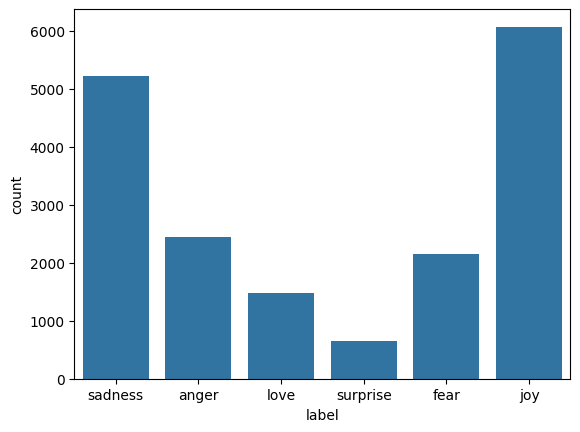

In [81]:
#lets see histogram

sns.countplot(x=combined_df["label"])


## Data Preprocessing

*lets divide this 6 feelings into 2 classes.
1. Positive Sentiment – “joy”,”love”,”surprise”

2. Negative Sentiment – “anger”,”sadness”,”fear”


Let's say 1 represents positive statement and 0 represents negative sentence.

In [82]:
def encode_into_two_classes(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [83]:
encode_into_two_classes(combined_df["label"])
combined_df

C:\Users\prabigya\AppData\Local\Temp\ipykernel_16140\924056506.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace ="sadness", value =0, inplace=True)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0
...,...,...
17995,im having ssa examination tomorrow in the morn...,0
17996,i constantly worry about their fight against n...,1
17997,i feel its important to share this info for th...,1
17998,i truly feel that if you are passionate enough...,1


<Axes: xlabel='label', ylabel='count'>

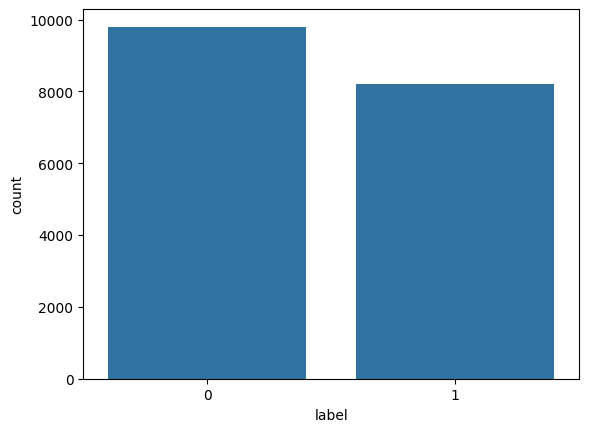

In [84]:
sns.countplot(x=combined_df["label"])

In [85]:
import enchant   #for spelling correction and checking
from nltk.metrics import edit_distance  # to find the case where spelling correction is needed
d = enchant.Dict("en_US")

from nltk.corpus import wordnet as wn
from nltk import pos_tag
from collections import defaultdict


#Lets define some function for replacement of common sentece use cases
replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'', ''),
 (r'wanna', 'want'),
 (r'gonna', 'going to'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would')
]
patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]

def replace_function(text):
    s = text
    for (pattern, repl) in patterns:
        s = re.sub(pattern, repl, s)
    return s




#the following function remove stopwords
def remove_stopwords(text):
    stopwords_list=stopwords.words("english")
    text_without_stopword=""
    for i in str(text).split():
        if i not in stopwords_list:
            text_without_stopword=text_without_stopword+" "+str(i).lower()
    return text_without_stopword.strip()




#the following function is used for spelling checking and correction
def correct_spellings_all(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if d.check(word):
            corrected_words.append(word)
        else:
            suggestions = d.suggest(word)
            if suggestions:
                if (edit_distance(word,suggestions[0])>1):
                    corrected_words.append(suggestions[0])
                else:
                    corrected_words.append(word)
            else:
                corrected_words.append(word)
    return ' '.join(corrected_words)




#the follwing function is used for lammetizing by finding the POS
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

lemmatizer = WordNetLemmatizer()


def lemmatize_sentence(text):
    words = nltk.word_tokenize(text)
    corrected_words = []
    for token, tag in pos_tag(words):
        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
        corrected_words.append(lemma)
    return ' '.join(corrected_words)

In [86]:
#combined_df["text"].apply([replace_function,remove_stopwords,correct_spellings_all,lemmatize_sentence])

In [87]:
# combined_df["proceessed_text"]=combined_df["text"].apply(replace_function).apply(remove_stopwords).apply(correct_spellings_all).apply(lemmatize_sentence)
# combined_df

## saved the preprocessed text
# combined_df.to_csv("processed_data_file.csv",index=False)

## The above lines are used for preprocessing text but it takes time to preprocess 
## This time, instead of preprocessing we will load the preprocessed csv file

combined_df=pd.read_csv("processed_data_file.csv")
combined_df

,text,label,proceessed_text
0,i didnt feel humiliated,0,didnt feel humiliate
1,i can go from feeling so hopeless to so damned...,0,go feeling hopeless damn hopeful around someon...
2,im grabbing a minute to post i feel greedy wrong,0,mi grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,1,ever feel nostalgic fireplace know still property
4,i am feeling grouchy,0,feel grouchy
...,...,...,...
17995,im having ssa examination tomorrow in the morn...,0,mi SSA examination tomorrow morning mi quite w...
17996,i constantly worry about their fight against n...,1,constantly worry fight nature push limit inner...
17997,i feel its important to share this info for th...,1,feel important share info experience thing
17998,i truly feel that if you are passionate enough...,1,truly feel passionate enough something stay tr...


In [88]:
combined_df.drop(columns=["text"],inplace=True)

#### Lets visualize the text frequency cloud in overall text

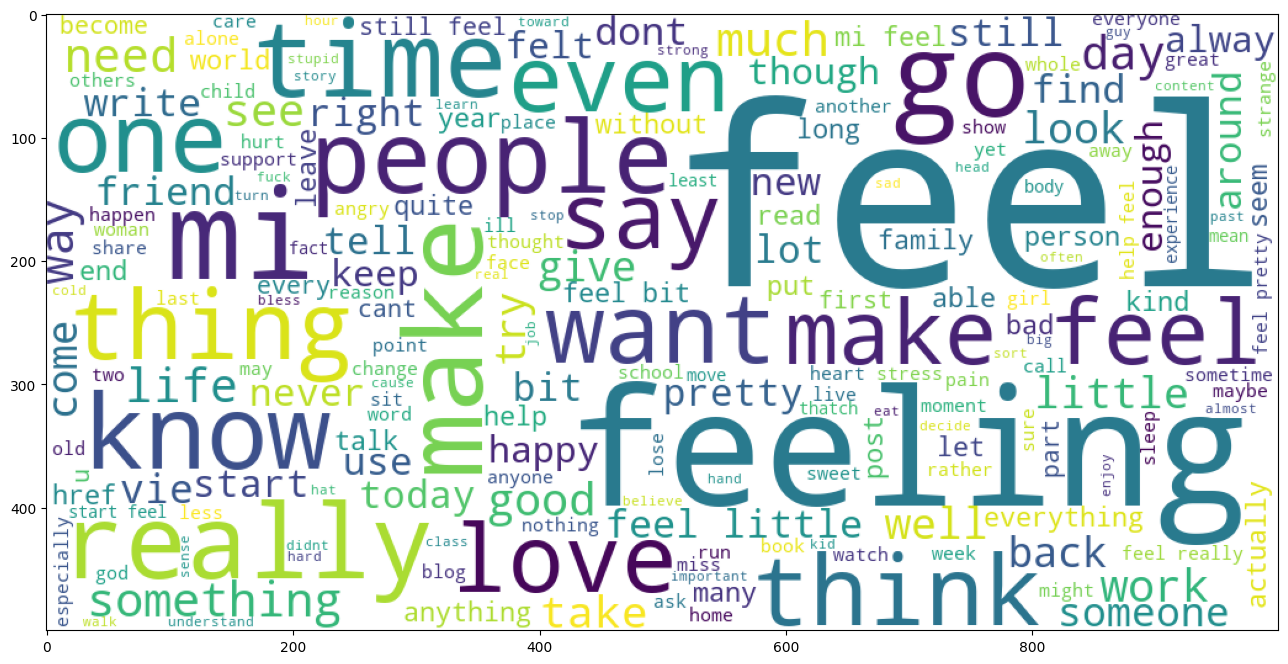

In [89]:
plt.figure(figsize=(20,8))
word_cloud = ""
for row in combined_df["proceessed_text"]:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

## Feature Extraction

We know machine learning algorithm works only on numerical data. So, in this step text is converted into numerical equivalent.


The basic ways are:
- **Bag of Words (BoW)**
- **TF-IDF (Term Frequency-Inverse Document Frequency)**
- **Word Embeddings**

### Bag of Words(Bow)

In this model, text (such as a sentence or a document) is represented as an unordered collection of words, disregarding grammar and word order but keeping track of the frequency of each word.

**Vocabulary:** The set of unique words in the corpus (all documents being analyzed).

**Vector Representation:** Each document is represented as a vector with the length equal to the size of the vocabulary. Each position in the vector corresponds to a word in the vocabulary, and the value at each position represents the frequency of that word in the document.

**Step-by-Step Process:**

**Tokenization:** Split each document into words.

- Document 1: ["The", "cat", "sat", "on", "the", "mat"]
- Document 2: ["The", "dog", "sat", "on", "the", "log"]
- Document 3: ["The", "cat", "and", "the", "dog", "are", "friends"]

**Normalization:** Convert to lowercase (and possibly remove punctuation).

- Document 1: ["the", "cat", "sat", "on", "the", "mat"]
- Document 2: ["the", "dog", "sat", "on", "the", "log"]
- Document 3: ["the", "cat", "and", "the", "dog", "are", "friends"]

**Create Vocabulary:** Identify the unique words in the corpus.

- **Vocabulary:** ["the", "cat", "sat", "on", "mat", "dog", "log", "and", "are", "friends"]

**Vector Representation:**

- Document 1: [2, 1, 1, 1, 1, 0, 0, 0, 0, 0]
- Document 2: [2, 0, 1, 1, 0, 1, 1, 0, 0, 0]
- Document 3: [2, 1, 0, 0, 0, 1, 0, 1, 1, 1]

Each vector represents the frequency of each word from the vocabulary in the corresponding document.

### TF-IDF (Term Frequency-Inverse Document Frequency)

It is a numerical representation that reflects how significant a word is to a document in the context of the entire corpus.

**Term Frequency (TF):**

- **Definition:** Measures how frequently a term (word) appears in a document.
- **Formula:**
  
  \[
  TF(t,d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
  \]

**Inverse Document Frequency (IDF):**

- **Definition:** Measures how important a term is across all documents in the corpus. It decreases the weight of terms that appear very frequently in many documents and increases the weight of terms that appear less frequently.
- **Formula:**
  
  \[
  IDF(t,D) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents containing term } t}\right)
  \]

**TF-IDF:**

- **Definition:** The product of TF and IDF, which balances the frequency of a term in a document with how unique it is across the corpus.
- **Formula:**
  
  \[
  TF\text{-}IDF(t,d,D) = TF(t,d) \times IDF(t,D)
  \]


### Word Embeddings

They are dense vector representations of words that capture semantic relationships between words based on their context in large text corpora. Word embeddings create low-dimensional, dense vectors where semantically similar words are close to each other in the vector space.

**Dense Vectors:** Unlike sparse vectors used in BoW and TF-IDF, word embeddings are dense, meaning they have fewer dimensions (typically 50-300) with most of the values being non-zero.

**Contextual Similarity:** Words that appear in similar contexts (i.e., neighboring words) have similar vectors. For example, "king" and "queen" would have similar vectors.

**Training Methods:**

- **Word2Vec:** Developed by Google, it includes two model architectures: Continuous Bag of Words (CBOW) and Skip-gram.
  - **CBOW:** Predicts the target word from its context.
  - **Skip-gram:** Predicts the context words from a target word.
- **GloVe (Global Vectors for Word Representation):** Developed by Stanford, it creates word embeddings by aggregating global word-word co-occurrence statistics from a corpus.
- **FastText:** Developed by Facebook, it extends Word2Vec by considering subword information, which helps in handling rare and out-of-vocabulary words.
- **Pre-trained Embeddings:** Models trained on large corpora (e.g., Google News, Wikipedia) that can be used directly for various NLP tasks. Examples include Word2Vec, GloVe, and FastText.

### Implementing BOW

In [90]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(combined_df["proceessed_text"])
X = traindata
y = combined_df["label"]
combined_df["proceessed_text"][0:10]

0                                 didnt feel humiliate
1    go feeling hopeless damn hopeful around someon...
2                mi grab minute post feel greedy wrong
3    ever feel nostalgic fireplace know still property
4                                         feel grouchy
5           vie feel little burdened lately wasnt sure
6    vie take milligram time recommend amount vie f...
7         feel confuse life teenager jade year old man
8    periastron year feel periastron perform well m...
9                                        feel romantic
Name: proceessed_text, dtype: object

In [91]:
cv = CountVectorizer(ngram_range = (1, 2))
traindata = cv.fit_transform(combined_df["proceessed_text"])
y = combined_df["label"]
print(len( cv.get_feature_names_out()))


112669


### Lets load testing dataset also

In [92]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])
X_test,y_test = test_df.text,test_df.label

#encode the labels into two classes , 0 and 1
encode_into_two_classes(y_test)
print(test_df)

                                                   text  label
0     im feeling rather rotten so im not very ambiti...      0
1             im updating my blog because i feel shitty      0
2     i never make her separate from me because i do...      0
3     i left with my bouquet of red and yellow tulip...      1
4       i was feeling a little vain when i did this one      0
...                                                 ...    ...
1995  i just keep feeling like someone is being unki...      0
1996  im feeling a little cranky negative after this...      0
1997  i feel that i am useful to my people and that ...      1
1998  im feeling more comfortable with derby i feel ...      1
1999  i feel all weird when i have to meet w people ...      0

[2000 rows x 2 columns]


C:\Users\prabigya\AppData\Local\Temp\ipykernel_16140\924056506.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace ="sadness", value =0, inplace=True)


In [93]:
# #pre-processing of text
# test_df["proceessed_text"]=test_df["text"].apply(replace_function).apply(remove_stopwords).apply(correct_spellings_all).apply(lemmatize_sentence)
# test_df

# # saved the preprocessed text
# test_df.to_csv("processed_test_data_file.csv",index=False)

## The above lines are used for preprocessing text but it takes time to preprocess 
## This time, instead of preprocessing we will load the preprocessed csv file

test_df=pd.read_csv("processed_test_data_file.csv")
test_df.drop(columns=["text"],inplace=True)
test_df

,label,proceessed_text
0,0,mi feel rather rotten mi ambitious right
1,0,mi update blog feel shitty
2,0,never make separate ever want feel like ashamed
3,1,leave bouquet red yellow tulip arm feeling sli...
4,0,feel little vain one
...,...,...
1995,0,keep feeling like someone unkind wrong think g...
1996,0,mi feel little cranky negative doctor appointment
1997,1,feel useful people give great feeling achievement
1998,1,mi feel comfortable derby feel though start st...


In [94]:
#convert text data into vectors
testdata = cv.transform(test_df["proceessed_text"])
print(len( cv.get_feature_names_out()))

112669


# Model Training

### Simply train in RandomForestAlgorithm

In [100]:
model = RandomForestClassifier()
model.fit(X,y)


Accuracy: 0.9385


In [101]:
y_pred =model.predict(testdata)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9385


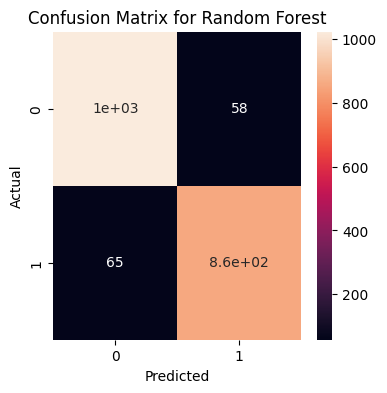

In [102]:
plt.figure(figsize=(4,4))

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

### HyperParameter Tuning

In [103]:
# parameters = {'max_features': ('auto','sqrt'),
#              'n_estimators': [100,200,500, 1000, 1500],
#              'max_depth': [5, 10, 15,None],
#              'min_samples_split': [2,5, 10, 15],
#              'min_samples_leaf': [1, 2, 5, 10],
#              'bootstrap': [True, False]}

# grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
# grid_search.fit(X,y)
# grid_search.best_params_

KeyboardInterrupt: 

In [ ]:
# for i in range(432):
#     print('Parameters: ',grid_search.cv_results_['params'][i])
#     print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
#     print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

In [113]:
# best fit
model_hyper_parameter_tuned = RandomForestClassifier(
                                      max_depth=None,
                                      n_estimators=100,
                                      min_samples_split=5,
                                      min_samples_leaf=1,
                                      bootstrap=True).fit(X, y)

In [110]:
y_pred_parameter_tuned =model_hyper_parameter_tuned.predict(testdata)
print(f'Accuracy after hyperparameter tuned: {accuracy_score(y_test, y_pred_parameter_tuned)}')

Accuracy after hyperparameter tuned: 0.9405


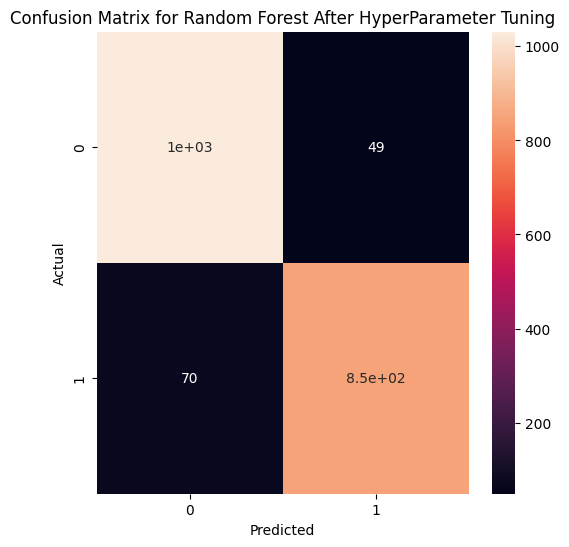

In [111]:
plt.figure(figsize=(6,6))

sns.heatmap(confusion_matrix(y_test,y_pred_parameter_tuned),annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest After HyperParameter Tuning")
plt.show()

### Prediction

input_sentence=""

.apply(replace_function).apply(remove_stopwords).apply(correct_spellings_all).apply(lemmatize_sentence)



In [ ]:
input_sentence=""
processed_text=lemmatize_sentence(correct_spellings_all(remove_stopwords(replace_function(input_sentence))))
transformed_input = cv.transform(processed_text)

### Saving model and cv

In [115]:
import pickle

with open('cv.pkl', 'wb') as f:
    pickle.dump(cv, f)
    f.close()

with open('sentiment_analysis_model.pkl', 'wb') as f:
    pickle.dump(model_hyper_parameter_tuned, f)
    f.close()
